# Import

In [7]:
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np
import wasabi
import seaborn as sns
import math
import scipy
pd.set_option('display.max_rows',4000)
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import missingno
import seaborn as sns
from pandas.plotting import scatter_matrix
from mpl_toolkits.mplot3d import Axes3D

In [9]:
from wasabi import Printer

p = Printer()
p.info('Q1 not done')
p.good('Q2 : More plotting needs to be done')
p.good('Q3.1')
p.fail('Q3.2')

In [11]:
def p2f(x):
    return float(x.strip('%'))

def plot_distribution(dataset, cols=5, width=20, height=15, hspace=0.2, wspace=0.5):
    plt.style.use('seaborn-whitegrid')
    fig = plt.figure(figsize=(width,height))
    fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=wspace, hspace=hspace)
    rows = math.ceil(float(dataset.shape[1]) / cols)
    for i, column in enumerate(dataset.columns):
        ax = fig.add_subplot(rows, cols, i + 1)
        ax.set_title(column)
        if dataset.dtypes[column] == np.object or dataset.dtypes[column] == '<M8[ns]':
            g = sns.countplot(x=column, data=dataset)
            substrings = [s.get_text()[:18] for s in g.get_xticklabels()]
            g.set(xticklabels=substrings)
            plt.yticks(rotation=0)
            plt.xticks(rotation=90)
        else:
            g = sns.distplot(dataset[column])
            plt.xticks(rotation=0)

In [13]:
path = '/home/shan/4th Sem/CH5019/Term project 2020/covid19-in-india'

# Loading data

__Common columns to merge the data on:__
*** 
- age has nothing in common with any other dataset
- cases, beds : State/UnionTerritory
- cases, icmr: Date
- cases, ind: Date, diagnosed_date ; State/UnionTerritory, detected_state
- cases, census: State / Union Territory
- beds, icmr: - 
- beds, ind: State/UT, detected_state
- beds, census: State/UT, State / Union Territory
- icmr, ind: DateTime,diagnosed_date
- icmr, census: -
- ind, census: detected_state, State / Union Territory

## Age

In [14]:
age = pd.read_csv(path+'/AgeGroupDetails.csv', index_col='Sno',converters={'Percentage':p2f})
print(age.shape)
age.name='age'
age.head()

(10, 3)


,AgeGroup,TotalCases,Percentage
Sno,,,
1,0-9,22,3.18
2,10-19,27,3.90
3,20-29,172,24.86
4,30-39,146,21.10
5,40-49,112,16.18


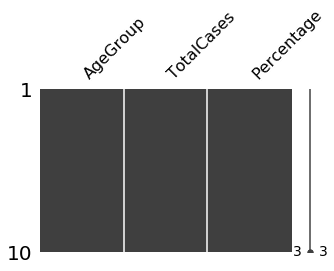

In [15]:
missingno.matrix(age,figsize=(5,3))

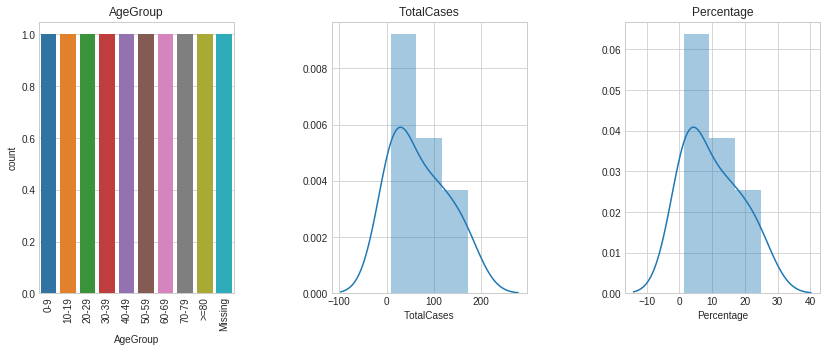

In [16]:
plot_distribution(age,cols=3, width=14, height=5, hspace=0.2, wspace=0.5)

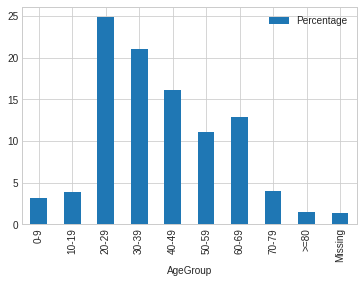

In [17]:
age.plot('AgeGroup','Percentage',kind='bar')

<font face = "Courier New" size = "3" color=Blue> From this we can tell that the maximum number of cases has occured in the age group of 20-29 </font>

## Cases

In [18]:
cases = pd.read_csv(path+'/covid_19_india.csv', index_col='Sno',parse_dates=True, na_values=['-'])
cases.Date = pd.to_datetime(cases.Date, dayfirst=True)
cases.name='cases'
print(cases.shape)
cases.head()

(1157, 8)


,Date,Time,State/UnionTerritory,ConfirmedIndianNational,ConfirmedForeignNational,Cured,Deaths,Confirmed
Sno,,,,,,,,
1,2020-01-30,6:00 PM,Kerala,1.0,0.0,0,0,1
2,2020-01-31,6:00 PM,Kerala,1.0,0.0,0,0,1
3,2020-02-01,6:00 PM,Kerala,2.0,0.0,0,0,2
4,2020-02-02,6:00 PM,Kerala,3.0,0.0,0,0,3
5,2020-02-03,6:00 PM,Kerala,3.0,0.0,0,0,3


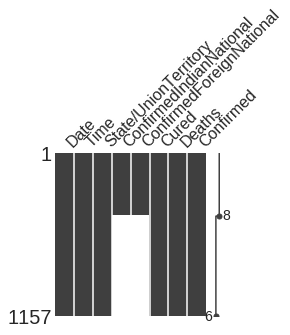

In [19]:
missingno.matrix(cases, figsize=(3,3))


<font face = "Courier New" size = "3" color=Blue> 
- We can see that 'ConfirmedIndianNational', 'ConfirmedForeignNational' have many missing values
- Assuming that there has been no entry of foreign nationals after the last available value, we find number of indian cases as (total confirmed-foreign cases)
</font>


In [20]:
#cases['ConfirmedForeignNational'] = cases['ConfirmedForeignNational'].fillna(method='ffill')
#This is wrong because the count must be taken state wise

In [21]:
cases['ConfirmedForeignNational'] = cases.groupby(['State/UnionTerritory'])['ConfirmedForeignNational'].ffill()

<font face = "Courier New" size = "3" color=Blue> 
- We can still see some missing values in 'ConfirmedForeignNational'; this is for those states whose initial value itself is NaN
- For those states, we assume there are no foreign nationals and set the value to be zero
</font>


In [22]:
cases['ConfirmedForeignNational'] = cases['ConfirmedForeignNational'].fillna(0)
cases['ConfirmedIndianNational']=cases['Confirmed']-cases['ConfirmedForeignNational']
for i,df in cases.groupby('Date'):
    print(cases.groupby('Date').get_group(i).shape[0],end=',')

<font face = "Courier New" size = "3" color=Blue> 
- This tells us that all the states that have cases are listed on a particular date  
- We also know that the counts for each state on any date is cumulative
</font>

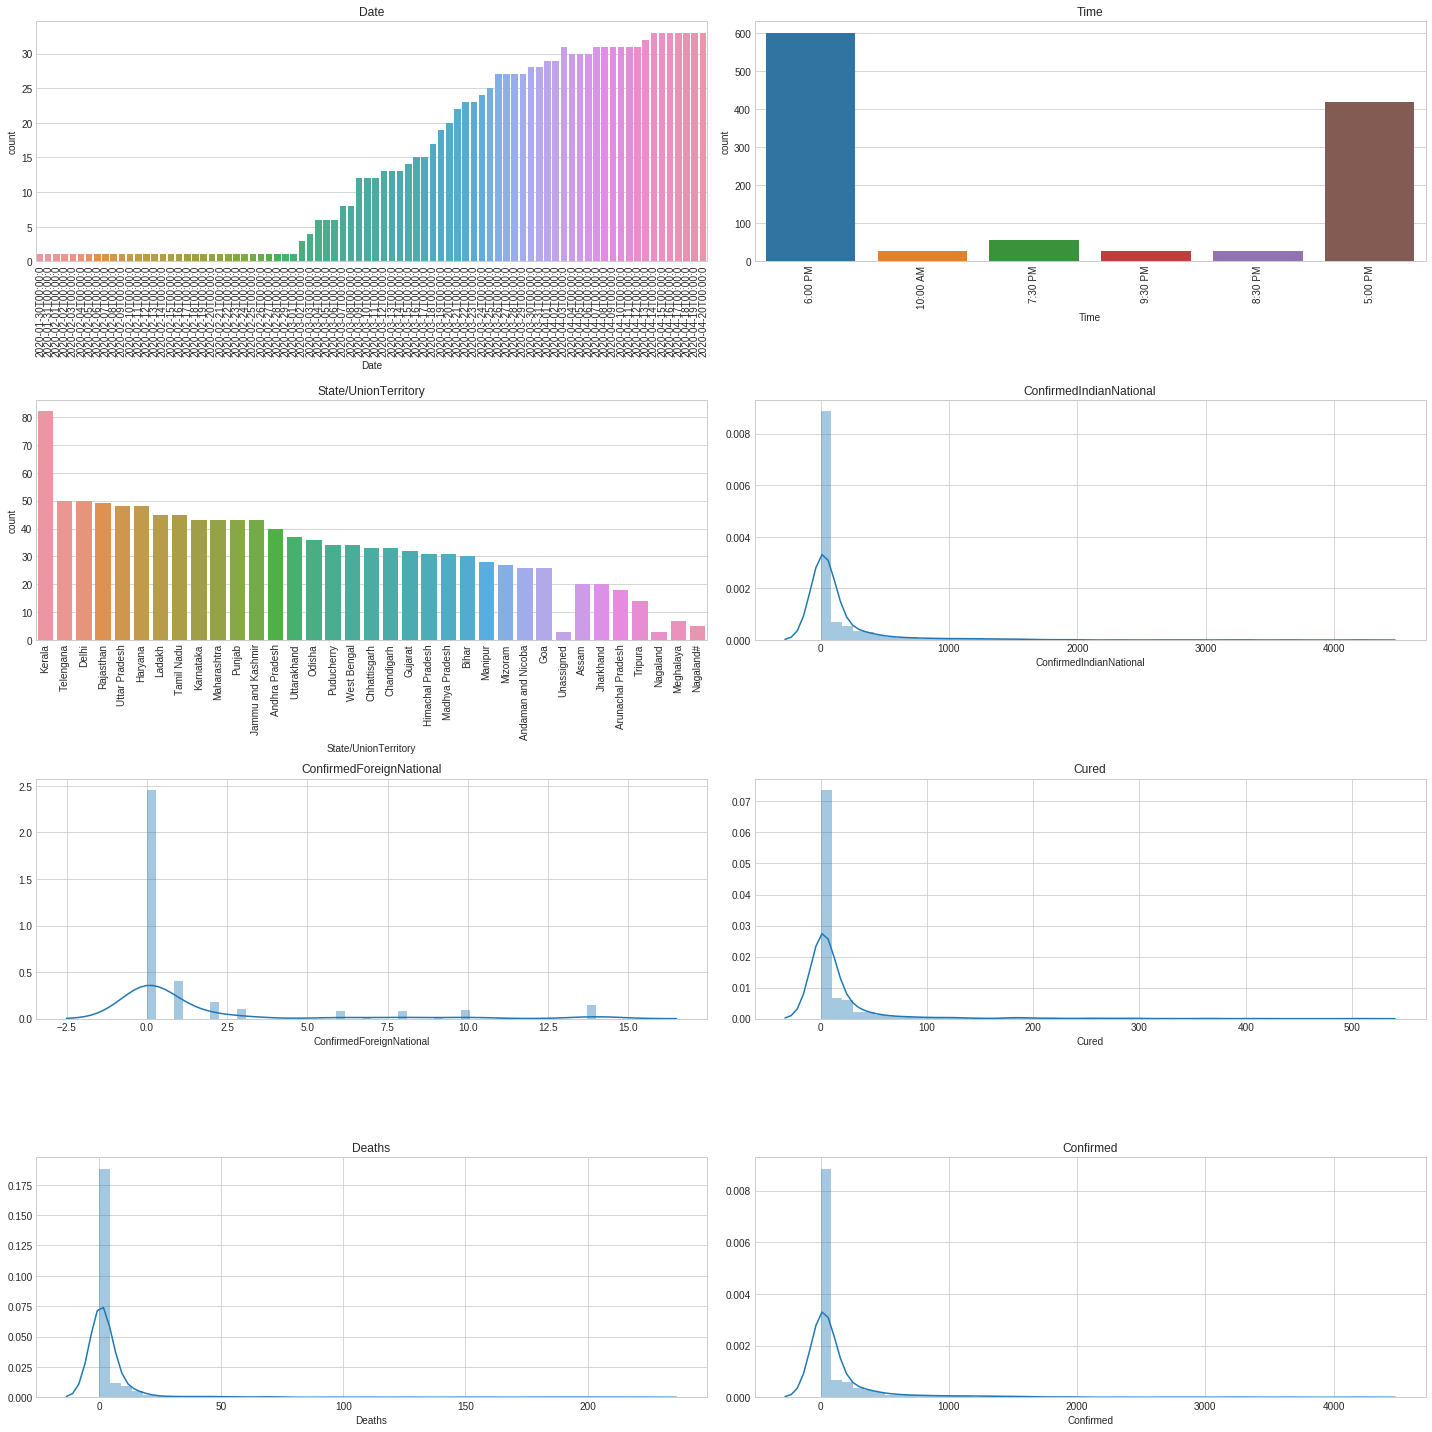

In [25]:
plot_distribution(cases,cols=2, width=20, height=20, hspace=0.2, wspace=0.5)
plt.tight_layout()

<font face = "Courier New" size = "3" color=Blue> 
From these graphs, we can conclude the following:
- There are many reading from the same date, which are of all states with their cumulative covid patient counts on that date
- The number of states reporting cases has gone up and the saturated (figure 1)
- Maximum number of reportings (not cases) come from Kerala. Thus Kerala is the state suffering from covid for the longest (figure 3)
- The frequency distributions for Confirmed cases, Deaths and Cured patients are long tailed
</font>

### Plotting

In [26]:
cases.head()

,Date,Time,State/UnionTerritory,ConfirmedIndianNational,ConfirmedForeignNational,Cured,Deaths,Confirmed
Sno,,,,,,,,
1,2020-01-30,6:00 PM,Kerala,1.0,0.0,0,0,1
2,2020-01-31,6:00 PM,Kerala,1.0,0.0,0,0,1
3,2020-02-01,6:00 PM,Kerala,2.0,0.0,0,0,2
4,2020-02-02,6:00 PM,Kerala,3.0,0.0,0,0,3
5,2020-02-03,6:00 PM,Kerala,3.0,0.0,0,0,3


<font face = "Courier New" size = "3" color=Blue> 
Possible plots
- Date vs number of confirmed, cured, dead (all states added)
- For each state, number of confirmed, cured, dead
- Date vs Indian cases, Foreign cases
    
</font>

In [27]:
country_cases=cases.resample('D', on='Date').sum()
country_cases.plot(figsize=(14,5))

<font face = "Courier New" size = "3" color=Blue> 
- The number of confirmed cases has been rising steeply (exponentially)
- The number of cured cases is also rising steeply however it is less steep than number of confirmed cases
- Number of deaths is approximately linear
</font>

In [29]:
y = country_cases.Confirmed.values
x=np.arange(y.shape[0])

a1,b1=np.polyfit(x, np.log(y), 1, w=np.sqrt(0.5*y**1.5))
ypred=np.exp(a1*x + b1)

plt.figure(figsize=(14,5))
plt.title("Confirmed Cases")
plt.plot(x, ypred, 'b--',label='Predicted Curve')
plt.plot(x,y,'r',label='Actual Curve')
plt.legend()

In [32]:
print('Predicted Curve: {0:.2f}*exp({1:.2f}*x)'.format(np.exp(b1),a1))
r2_score(y, ypred)

Predicted Curve: 2.04*exp(0.11*x)


/home/shan/anaconda3/lib/python3.6/site-packages/pandas/plotting/_matplotlib/core.py:338: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


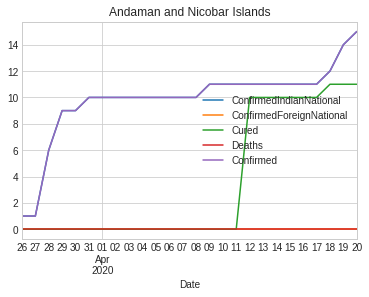

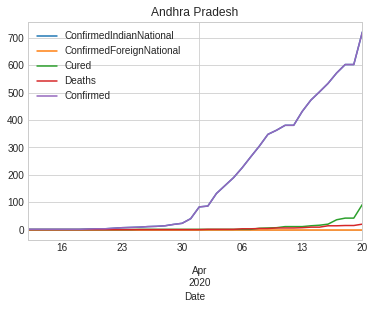

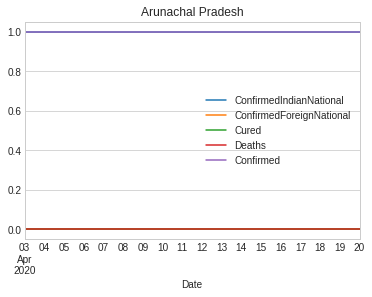

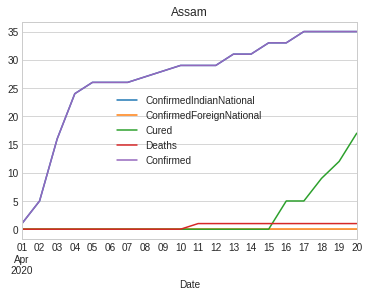

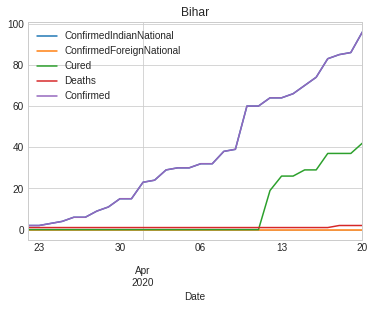

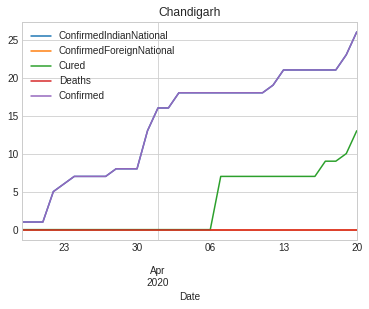

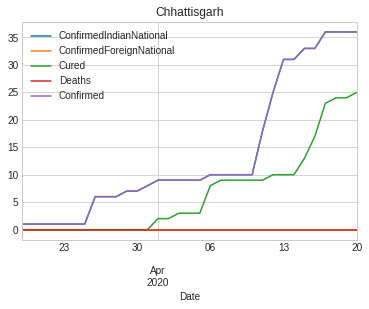

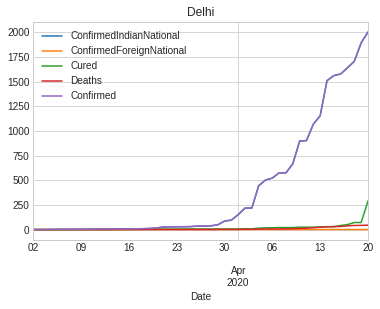

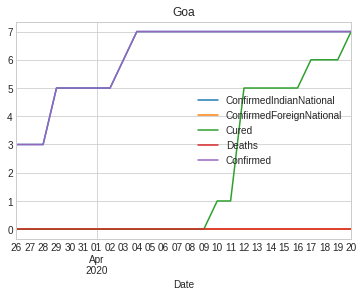

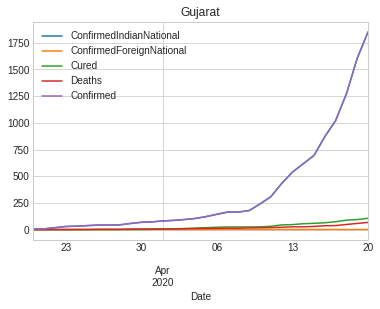

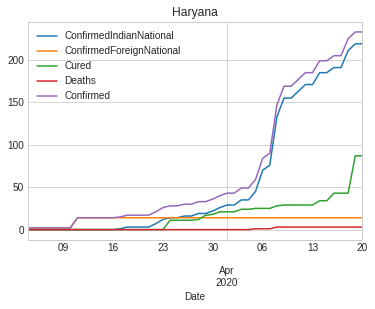

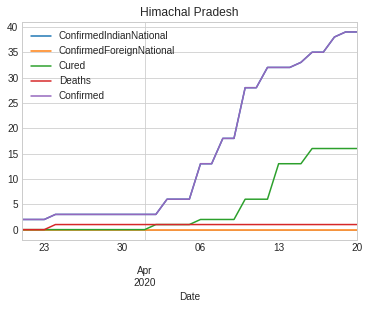

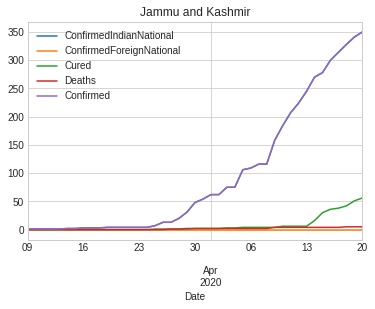

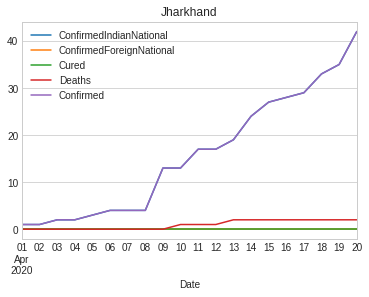

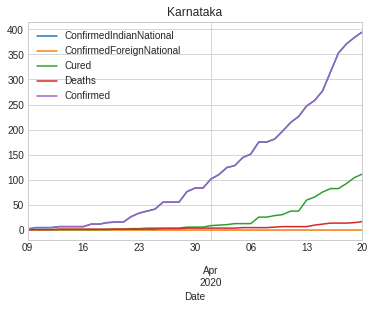

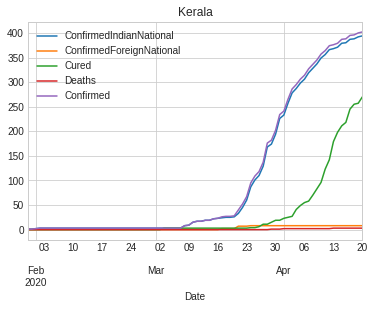

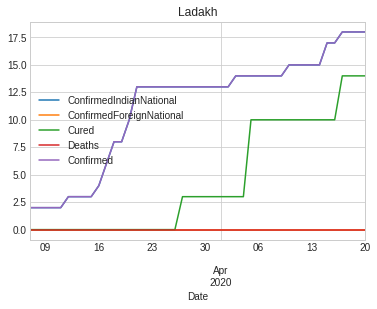

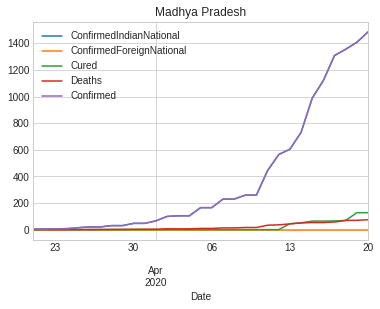

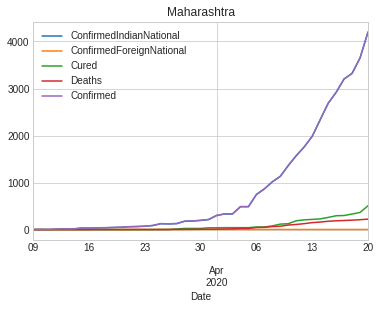

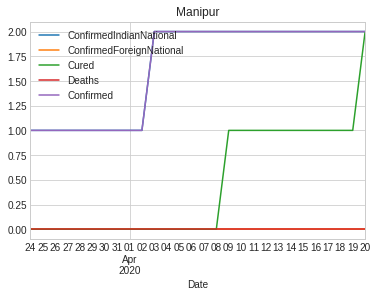

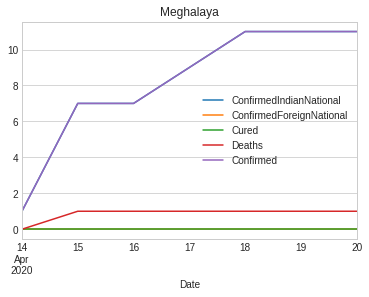

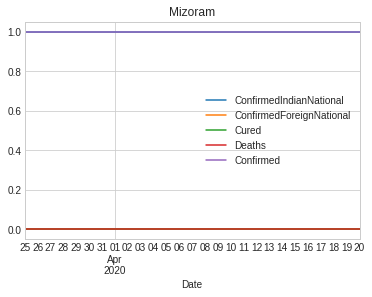

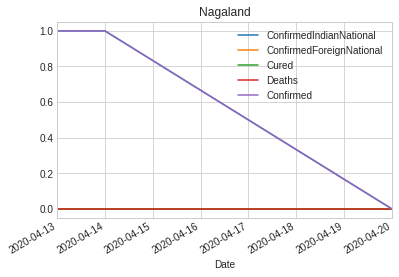

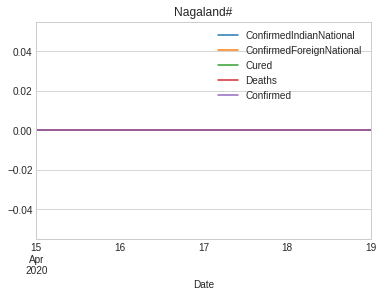

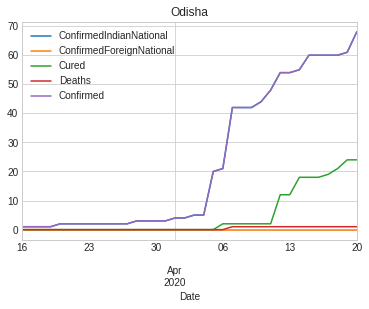

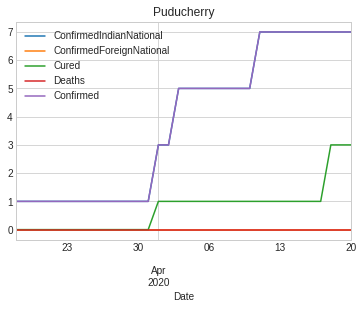

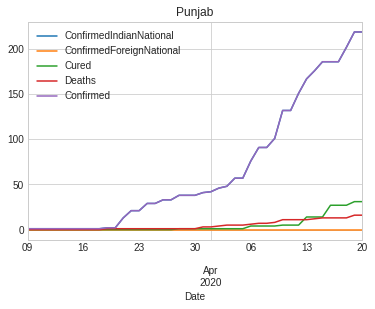

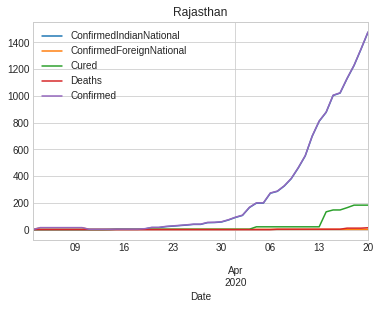

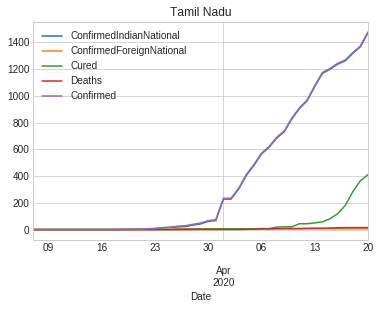

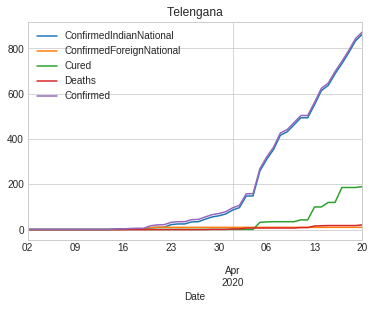

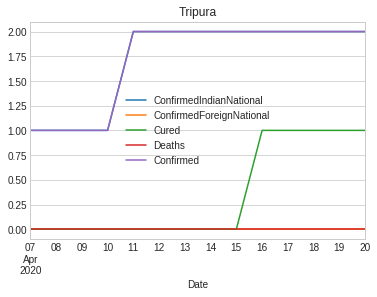

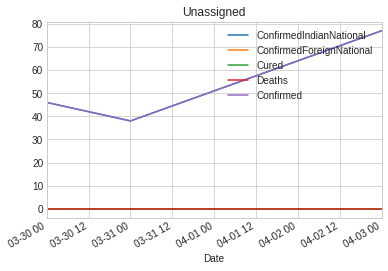

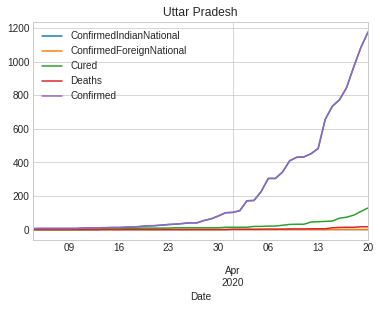

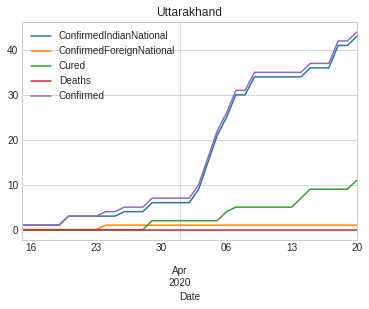

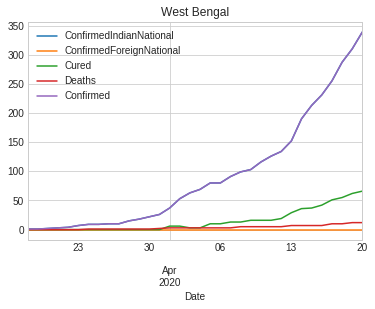

In [38]:
grouped = cases.groupby('State/UnionTerritory')
for name,df in grouped:
    i=cases.groupby('State/UnionTerritory').get_group(name)
    i.plot("Date",title=name)
plt.show()


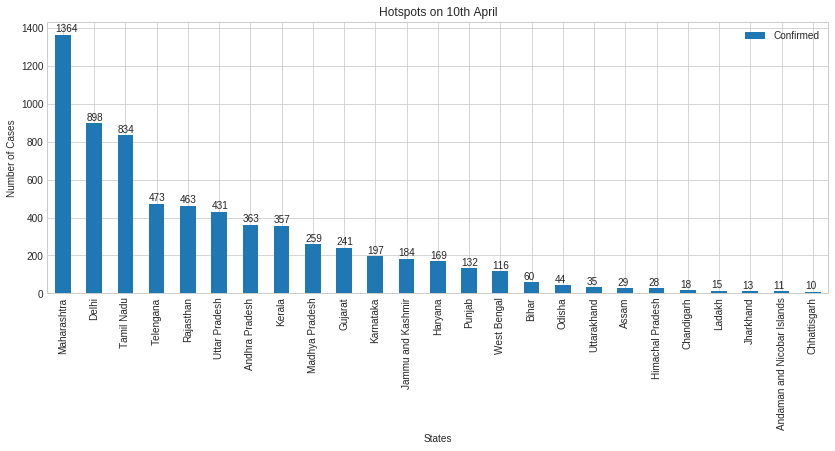

In [39]:
april10=cases.groupby('Date').get_group('2020-04-10')
ax=april10[april10.Confirmed>=10].sort_values(by='Confirmed',ascending=False).plot('State/UnionTerritory','Confirmed',kind='bar',title='Hotspots on 10th April',
                                    figsize=(14,5))
for p in ax.patches:
    ax.annotate(np.round(p.get_height(),decimals=2),(p.get_x(), p.get_height()+15))
ax.set_xlabel("States")
ax.set_ylabel('Number of Cases')
plt.show()

In [40]:
april10[['State/UnionTerritory','Confirmed']][april10.Confirmed<10].set_index('State/UnionTerritory')

,Confirmed
State/UnionTerritory,
Arunachal Pradesh,1
Goa,7
Manipur,2
Mizoram,1
Puducherry,5
Tripura,1


<font face = "Courier New" size = "3" color=Blue> 
- Maharashtra has the maximum number of cases closely followed by Delhi
</font>

## Beds

In [44]:
beds = pd.read_csv(path+'/HospitalBedsIndia.csv', index_col='Sno',thousands=',')
print(beds.shape)
beds.name='beds'
beds.head()

(37, 11)


,State/UT,NumPrimaryHealthCenters_HMIS,NumCommunityHealthCenters_HMIS,NumSubDistrictHospitals_HMIS,NumDistrictHospitals_HMIS,TotalPublicHealthFacilities_HMIS,NumPublicBeds_HMIS,NumRuralHospitals_NHP18,NumRuralBeds_NHP18,NumUrbanHospitals_NHP18,NumUrbanBeds_NHP18
Sno,,,,,,,,,,,
1,Andaman & Nicobar Islands,27,4,NaN,3,34,1246,27,575,3,500
2,Andhra Pradesh,1417,198,31.0,20,1666,60799,193,6480,65,16658
3,Arunachal Pradesh,122,62,NaN,15,199,2320,208,2136,10,268
4,Assam,1007,166,14.0,33,1220,19115,1176,10944,50,6198
5,Bihar,2007,63,33.0,43,2146,17796,930,6083,103,5936


In [46]:
beds.isna().sum()/beds.shape[0]*100

State/UT                             0.000000
NumPrimaryHealthCenters_HMIS         0.000000
NumCommunityHealthCenters_HMIS       0.000000
NumSubDistrictHospitals_HMIS        18.918919
NumDistrictHospitals_HMIS            0.000000
TotalPublicHealthFacilities_HMIS     0.000000
NumPublicBeds_HMIS                   0.000000
NumRuralHospitals_NHP18              0.000000
NumRuralBeds_NHP18                   0.000000
NumUrbanHospitals_NHP18              0.000000
NumUrbanBeds_NHP18                   0.000000
dtype: float64

In [47]:
print('Sum:',beds['NumSubDistrictHospitals_HMIS'].iloc[:-1].sum())
print('Total:',beds['NumSubDistrictHospitals_HMIS'].iloc[-1])

Sum: 1255.0
Total: 1255.0


<font face = "Courier New" size = "3" color=Blue> 
- NumSubDistrictHospitals_HMIS has has 19% missing values, however, on adding the remaining values, it equals the last row All India value. Thus, the NaN values must be replaced with zero
</font>

In [48]:
beds.fillna(0,inplace=True)

In [49]:
beds.dtypes

State/UT                             object
NumPrimaryHealthCenters_HMIS          int64
NumCommunityHealthCenters_HMIS        int64
NumSubDistrictHospitals_HMIS        float64
NumDistrictHospitals_HMIS             int64
TotalPublicHealthFacilities_HMIS      int64
NumPublicBeds_HMIS                    int64
NumRuralHospitals_NHP18               int64
NumRuralBeds_NHP18                    int64
NumUrbanHospitals_NHP18               int64
NumUrbanBeds_NHP18                    int64
dtype: object

<font face = "Courier New" size = "3" color=Blue> 
- Here, countplot or displot does not have much meaning because these count the number of time the numbers/categorical variables occur in a column. Here, each state would occur only once.
- Displots would tell us how many states have the same number of hospitals/beds
    
</font>

## Individual Cases

In [51]:
ind = pd.read_csv(path+'/IndividualDetails.csv', index_col='id',parse_dates=True)
print(ind.shape)
ind.name='ind'
ind['diagnosed_date'] = pd.to_datetime(ind['diagnosed_date'])
ind.dtypes

missingno.matrix(ind)

ind.isna().sum()

### Hotspots

ind=ind.drop('government_id',axis=1)

for i in ind.groupby('detected_state').groups:
    q=ind.groupby('detected_state').get_group(i)
    ind.groupby('detected_state').get_group(i).fillna(q.mode().iloc[0],inplace=True)

ind.groupby('detected_state').get_group('Kerala').isna().sum()/ind.groupby('detected_state').get_group('Kerala').shape[0]

ind.detected_city = ind.groupby(['detected_state'],sort=False).detected_city.apply(lambda x: x.fillna(x.mode()))

ind.isna().sum()

grouped=ind.groupby('detected_state')

grouped.detected_city.apply(pd.Series.mode)

ind['detected_city'] = ind.detected_city.dropna().groupby([ind.detected_state]).transform(lambda x: x.fillna(x.mode().iat[0]))

pd.set_option('display.max_rows',20000)
ind

(18032, 10)


government_id                 object
diagnosed_date        datetime64[ns]
age                           object
gender                        object
detected_city                 object
detected_district             object
detected_state                object
nationality                   object
status_change_date            object
notes                         object
dtype: object

## ICMR Testing Details


In [50]:
icmr= pd.read_csv('Dataset_Question3/ICMRTestingDetails.csv', delimiter='\t', index_col='SNo',parse_dates=True)
print(icmr.shape)
icmr.name='icmr'
icmr

(16, 5)


,DateTime,TotalSamplesTested,TotalIndividualsTested,TotalPositiveCases,Source
SNo,,,,,
1,13-03-2020 00:00,6500,5900,78,Press_Release_ICMR_13March2020.pdf
2,18-03-2020 18:00,13125,12235,150,ICMR_website_update_18March_6PM_IST.pdf
3,19-03-2020 10:00,13316,12426,168,ICMR_website_update_19March_10AM_IST_V2.pdf
4,19-03-2020 18:00,14175,13285,182,ICMR_website_update_19March_6PM_IST.pdf
5,20-03-2020 10:00,14376,13486,206,ICMR_website_update_20March_10AM_IST.pdf
6,20-03-2020 18:00,15404,14514,236,ICMR_website_update_20March_6PM_IST.pdf
7,21-03-2020 10:00,15701,14811,271,ICMR_website_update_21March_10AM_IST.pdf
8,21-03-2020 18:00,16911,16021,315,ICMR_website_update_21March_6PM_IST.pdf
9,22-03-2020 10:00,16999,16109,341,ICMR_website_update_22March_10AM_IST.pdf


In [59]:
icmr['DateTime']=pd.to_datetime(icmr['DateTime']).dt.date
icmr=icmr.drop('Source',axis=1)
icmr['DateTime']=pd.to_datetime(icmr['DateTime'])
icmr.info()   

In [70]:
s = icmr.resample('D', on='DateTime').sum().reset_index()
icmr=s.drop([1,2,3,4],axis=0)

In [85]:
country_cases.loc['2020-04-10']

ConfirmedIndianNational     6714.0
ConfirmedForeignNational      47.0
Cured                        516.0
Deaths                       206.0
Confirmed                   6761.0
Name: 2020-04-10 00:00:00, dtype: float64

In [87]:
icmr['Testing Rate'] = icmr.TotalPositiveCases/icmr.TotalSamplesTested

In [88]:
icmr

,DateTime,TotalSamplesTested,TotalIndividualsTested,TotalPositiveCases,Testing Rate
0,2020-03-13,6500,5900,78,0.012000
5,2020-03-18,13125,12235,150,0.011429
6,2020-03-19,27491,25711,350,0.012731
7,2020-03-20,29780,28000,442,0.014842
8,2020-03-21,32612,30832,586,0.017969
9,2020-03-22,35126,33346,737,0.020982
10,2020-03-23,39090,37310,886,0.022666
11,2020-03-24,43558,41778,1018,0.023371
12,2020-03-25,48072,46292,1120,0.023298


In [86]:
(1.1**10)*6761

17536.292772736117

In [89]:
(17536-6761)/0.023298

462486.0503047472

<font face = "Courier New" size = "3" color=Blue> 
- As of 10th April 2020, there are 6761 confirmed cases
- With a growth rate of 10% we can assume the number of positive cases to be 17536
- Considering the last testing rate, 0.023298, the number of samples will be = 

    
</font>